# Image Classification
In this project we classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects.

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 55:
Image - Min Value: 17 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


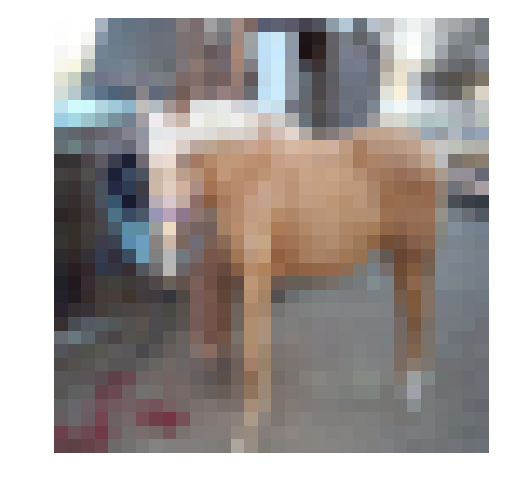

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 5
sample_id = 55
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    As there are 255 colours, we will divide the colours by 255 to get
    it to be within the range of 0 to 1. 
    for example 185 / 255 is .619
    We do this to make the data easier to work with
    """
    normal = x / 255.
    
    return normal


tests.test_normalize(normalize)

Tests Passed


### One-hot encode

In [4]:
import tensorflow as tf
from sklearn import preprocessing

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels    
    
    array with lots of 0s except a 1 where there is the thing we want
    """
    
    lb = preprocessing.LabelBinarizer()
    lb.fit(x)
    lb.classes_ = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    print(lb.classes_)
    return lb.transform(x)


tests.test_one_hot_encode(one_hot_encode)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Tests Passed


## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# Check Point
The preprocessed data has been saved to disk.

In [6]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """    
    print(*image_shape)
    tensor = tf.placeholder(tf.float32, 
                            shape=[None, image_shape[0], image_shape[1], image_shape[2]],
                           name="x")
    return tensor


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    print(n_classes)
    y = tf.placeholder(tf.float32, (None, n_classes), name="y")
    return y


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    keep = tf.placeholder(tf.float32, (None), name="keep_prob")
    return keep


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

32 32 3
Image Input Tests Passed.
10
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    
    tensor_shape = int(x_tensor.get_shape()[3])
    
    # Generate values with tf.truncated_normal
    weights = tf.Variable(tf.truncated_normal([*conv_ksize, tensor_shape, conv_num_outputs], 
                                              mean=0, stddev=.1))
    print(weights)
    
    bias = tf.Variable(tf.zeros(shape=[conv_num_outputs], dtype=tf.float32))
    print(bias)
    
    result = tf.nn.conv2d(x_tensor, weights, strides=[1, *conv_strides, 1], padding="SAME")
    print(result)
    
    result = result + bias
    print(result)
    
    #Activation
    result = tf.nn.elu(result)
    
    # result = tf.nn.max_pool(result, [1, *pool_ksize, 1], [1, *pool_strides, 1], padding="SAME")    
    print(result)
    
    return result


# tests.test_con_pool(conv2d_maxpool)

### Flatten Layer

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    return tf.contrib.layers.flatten(x_tensor)


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer

In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs)


tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    return tf.contrib.layers.fully_connected(x_tensor, 
                                             num_outputs, activation_fn=None)


tests.test_output(output)

Tests Passed


### Show Stats

In [12]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    print("Loss", session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0}))
    print("Accuracy", session.run(accuracy, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0}))
    print("Validation",session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0}))


### Create Convolutional Model

In [47]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    pool_ksize = (4, 4)
    pool_strides = (4, 4)
    
    conv_ksize = (3, 3)
    conv_num_outputs = 96
    conv_strides = (2, 2)
    net = conv2d_maxpool(x, conv_num_outputs, 
                         conv_ksize, conv_strides, 
                         pool_ksize, pool_strides)
    net = conv2d_maxpool(net, conv_num_outputs, 
                         conv_ksize, conv_strides, 
                         pool_ksize, pool_strides)
    
    
    net = tf.nn.dropout(net, keep_prob)
    
    
    conv_num_outputs = 192
    conv_strides = (2, 2)
    net = conv2d_maxpool(net, conv_num_outputs, 
                         conv_ksize, conv_strides, 
                         pool_ksize, pool_strides)
    net = conv2d_maxpool(net, conv_num_outputs, 
                         conv_ksize, conv_strides, 
                         pool_ksize, pool_strides)
    
    net = tf.nn.dropout(net, keep_prob)
    
    conv_ksize = (1, 1)
    conv_strides = (1, 1)
    net = conv2d_maxpool(net, conv_num_outputs, 
                         conv_ksize, conv_strides, 
                         pool_ksize, pool_strides)
    
    conv_num_outputs = 16
    net = conv2d_maxpool(net, conv_num_outputs, 
                         conv_ksize, conv_strides, 
                         pool_ksize, pool_strides)
    

    
    net = tf.contrib.layers.avg_pool2d(net, [2,2])
    
    net = flatten(net)
        
    # Apply an Output Layer
    net = output(net, 10)
    
    return net


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

32 32 3
10
Tensor("Variable/read:0", shape=(3, 3, 3, 96), dtype=float32)
Tensor("Variable_1/read:0", shape=(96,), dtype=float32)
Tensor("Conv2D:0", shape=(?, 16, 16, 96), dtype=float32)
Tensor("add:0", shape=(?, 16, 16, 96), dtype=float32)
Tensor("Elu:0", shape=(?, 16, 16, 96), dtype=float32)
Tensor("Variable_2/read:0", shape=(3, 3, 96, 96), dtype=float32)
Tensor("Variable_3/read:0", shape=(96,), dtype=float32)
Tensor("Conv2D_1:0", shape=(?, 8, 8, 96), dtype=float32)
Tensor("add_1:0", shape=(?, 8, 8, 96), dtype=float32)
Tensor("Elu_1:0", shape=(?, 8, 8, 96), dtype=float32)
Tensor("Variable_4/read:0", shape=(3, 3, 96, 192), dtype=float32)
Tensor("Variable_5/read:0", shape=(192,), dtype=float32)
Tensor("Conv2D_2:0", shape=(?, 4, 4, 192), dtype=float32)
Tensor("add_2:0", shape=(?, 4, 4, 192), dtype=float32)
Tensor("Elu_2:0", shape=(?, 4, 4, 192), dtype=float32)
Tensor("Variable_6/read:0", shape=(3, 3, 192, 192), dtype=float32)
Tensor("Variable_7/read:0", shape=(192,), dtype=float32)
Tenso

## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.

In [14]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
           
    session.run(optimizer,
                feed_dict = {x:feature_batch, y:label_batch, keep_prob:keep_probability})


tests.test_train_nn(train_neural_network)

Tests Passed


### Hyperparameters

In [43]:
epochs = 10
batch_size = 64
keep_probability = .7

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch.

In [46]:
"""
New test based on:
https://arxiv.org/pdf/1412.6806.pdf

"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...


InvalidArgumentError: stride must be less than or equal to kernel size
	 [[Node: gradients/AvgPool2D/AvgPool_grad/AvgPoolGrad = AvgPoolGrad[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 8, 8, 1], _device="/job:localhost/replica:0/task:0/cpu:0"](gradients/AvgPool2D/AvgPool_grad/Shape, gradients/Flatten/Reshape_grad/Reshape)]]

Caused by op 'gradients/AvgPool2D/AvgPool_grad/AvgPoolGrad', defined at:
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-ffa36c5a13bc>", line 80, in <module>
    optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(cost)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\training\optimizer.py", line 279, in minimize
    grad_loss=grad_loss)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\training\optimizer.py", line 345, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 482, in gradients
    in_grads = grad_fn(op, *out_grads)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\ops\nn_grad.py", line 410, in _AvgPoolGrad
    data_format=op.get_attr("data_format"))
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 148, in _avg_pool_grad
    data_format=data_format, name=name)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\framework\ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\framework\ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'AvgPool2D/AvgPool', defined at:
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-ffa36c5a13bc>", line 73, in <module>
    logits = conv_net(x, keep_prob)
  File "<ipython-input-45-ffa36c5a13bc>", line 50, in conv_net
    net = tf.contrib.layers.avg_pool2d(net, [2,2], [8,8])
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 177, in func_with_args
    return func(*args, **current_args)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 128, in avg_pool2d
    outputs = layer.apply(inputs)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\layers\base.py", line 303, in apply
    return self.__call__(inputs, **kwargs)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\layers\base.py", line 273, in __call__
    outputs = self.call(inputs, **kwargs)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\layers\pooling.py", line 277, in call
    data_format=utils.convert_data_format(self.data_format, 4))
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1765, in avg_pool
    name=name)
  File "C:\anthony-ide\Anaconda3\envs\tflearn\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 50, in _avg_pool
    data_format=data_format, name=name)

InvalidArgumentError (see above for traceback): stride must be less than or equal to kernel size
	 [[Node: gradients/AvgPool2D/AvgPool_grad/AvgPoolGrad = AvgPoolGrad[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 8, 8, 1], _device="/job:localhost/replica:0/task:0/cpu:0"](gradients/AvgPool2D/AvgPool_grad/Shape, gradients/Flatten/Reshape_grad/Reshape)]]


### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [42]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss 2.1603
Accuracy 0.275
Validation 0.2548
Epoch  1, CIFAR-10 Batch 2:  Loss 1.71053
Accuracy 0.35
Validation 0.345
Epoch  1, CIFAR-10 Batch 3:  Loss 1.46078
Accuracy 0.45
Validation 0.3806
Epoch  1, CIFAR-10 Batch 4:  Loss 1.64963
Accuracy 0.4
Validation 0.3794
Epoch  1, CIFAR-10 Batch 5:  Loss 1.75752
Accuracy 0.45
Validation 0.412
Epoch  2, CIFAR-10 Batch 1:  Loss 1.74079
Accuracy 0.425
Validation 0.426
Epoch  2, CIFAR-10 Batch 2:  Loss 1.44942
Accuracy 0.475
Validation 0.438
Epoch  2, CIFAR-10 Batch 3:  Loss 1.11097
Accuracy 0.65
Validation 0.4532
Epoch  2, CIFAR-10 Batch 4:  Loss 1.39879
Accuracy 0.525
Validation 0.4486
Epoch  2, CIFAR-10 Batch 5:  Loss 1.73115
Accuracy 0.35
Validation 0.4564
Epoch  3, CIFAR-10 Batch 1:  Loss 1.79661
Accuracy 0.525
Validation 0.4682
Epoch  3, CIFAR-10 Batch 2:  Loss 1.33403
Accuracy 0.525
Validation 0.476
Epoch  3, CIFAR-10 Batch 3:  Loss 1.04343
Accuracy 0.625
Validation 0.477
Epoch  3, CIFAR-10 Batch 4:

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.5997213375796179



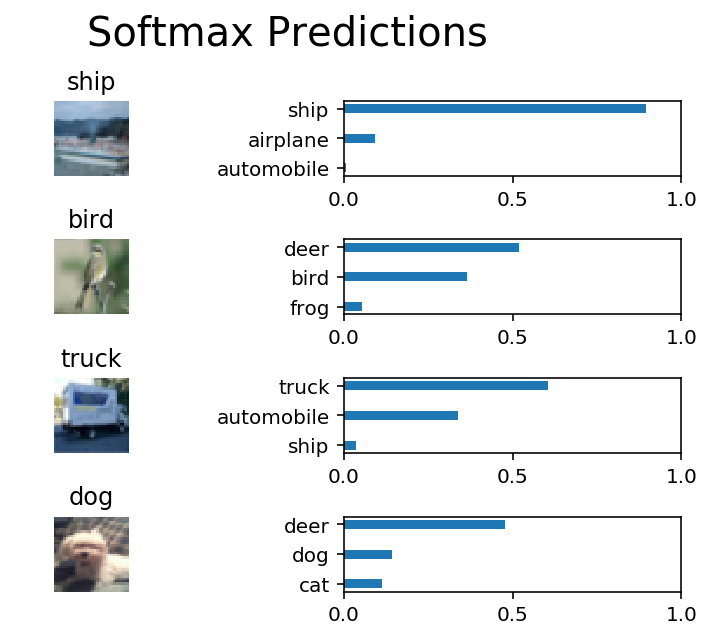

In [44]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.